In [40]:
import re
import pandas as pd
import numpy as np

In [41]:
# # Saves dictionary in same format
# np.save('my_file.npy', all_desc) 

# # # Loads dictionary in same format so we don't have to webscrape all the time
read_dictionary = np.load('my_file.npy').item()

In [42]:
edu  = read_dictionary

In [43]:
edu.keys()

dict_keys(['EDUCATION', 'BUSINESS', 'DATING', 'SPORTS', 'WEATHER', 'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'BEAUTY', 'MUSIC_AND_AUDIO', 'NEWS_AND_MAGAZINES', 'SOCIAL', 'SHOPPING', 'PRODUCTIVITY', 'PHOTOGRAPHY', 'MEDICAL', 'PARENTING', 'COMMUNICATION', 'TOOLS'])

# NLTK Clean up

In [44]:
import nltk
import sklearn

from nltk.collocations import *
from nltk import FreqDist, word_tokenize
import string, re
from nltk.stem.snowball import SnowballStemmer

In [45]:
# patter to capture using regex
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [46]:
# stop words
from nltk.corpus import stopwords
stopwords.words("english")

stop_words = set(stopwords.words('english'))

In [47]:
# stem words
stemmer = SnowballStemmer("english")

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [49]:
def text_cleaner(description):
    ''''''
    tokens_raw = nltk.regexp_tokenize(description, pattern)
    tokens = [i.lower() for i in tokens_raw]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens_stopped]
    cleaned = ' '.join(stemmed)
    return cleaned

In [50]:
def dict_cleaner(dictionary):
    description_list = []
    for c, d in dictionary.items():
        for description in d:
            cleaned = text_cleaner(description)
            description_list.append(cleaned)
    return description_list

In [51]:
# description list is a list of all descriptions stemmed and in order
description_list = dict_cleaner(edu)

## Frequency Distributions

In [88]:
i = 0
listy = []
for key in edu.keys():
    string = ''
    for x in range(i, i + 60):
        string += description_list[i]
    listy.append(string)
    i += 60

In [153]:
def get_most_common(keys, lis_t, n_words=50):
    key_words = []
    for key, string in zip(keys, lis_t):
        meta_freqdist = FreqDist(string.split())
        key_words.append((key, meta_freqdist.most_common(n_words)))
    return key_words

In [154]:
key_words = get_most_common(edu.keys(), listy)

In [151]:
# graphs words vs frequency
# meta_freqdist.plot(30,cumulative=False);

### Building wordclouds based on key_words

In [185]:
def build_word_cloud(tuppple):
    words = [x[0] for x in tuppple[1]]
    colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(30)]
#     weights = [random.randint(15, 35) for i in range(30)]
    weights = [round(x[1]/10) for x in tuppple[1]]

    data = go.Scatter(x=[random.random() for i in range(30)],
                     y=[random.random() for i in range(30)],
                     mode='text',
                     text=words,
                     marker={'opacity': 0.3},
                     textfont={'size': weights,
                               'color': colors})
    layout = go.Layout({ 'title' : f'{tuppple[0]}',
                        'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
    fig = go.Figure(data=[data], layout=layout)

    plot(fig)


## tf-idf

In [102]:
response = tfidf.fit_transform(description_list)

df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

In [103]:
non_zero_cols = response.nnz / float(response.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Reviews: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(response.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Reviews: 112.69537037037037
Percentage of columns containing 0: 0.9914657046292791


In [104]:
# Because we had exactly 60 items in each category this creates a list
# with 60 items of each key.
def create_labels(dictionary):
    x = dictionary.keys()
    new_list = []
    for c in x: 
        s = [c] * len(dictionary[c])
        new_list += s
    return new_list

In [105]:
labels = create_labels(edu)

In [106]:
len(labels)

1080

In [107]:
df.shape

(1080, 13205)

In [108]:
df['labels'] = labels

In [109]:
df.tail()

,aa,aac,aaptiv,aarp,aask,ab,abajo,abandon,abc,abcmous,...,zoomterrain,zoomwithushav,zoosk,zte,zulili,zulu,zulufor,zulupermiss,zumba,labels
1075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOOLS
1076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOOLS
1077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOOLS
1078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOOLS
1079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOOLS


In [110]:
df.describe()

,aa,aac,aaptiv,aarp,aask,ab,abajo,abandon,abc,abcmous,...,zoompres,zoomterrain,zoomwithushav,zoosk,zte,zulili,zulu,zulufor,zulupermiss,zumba
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.000033,0.000234,0.000172,0.000068,0.000062,0.001763,0.000017,0.000144,0.001015,0.000834,...,0.000108,0.000056,0.000108,0.000713,0.000037,0.000225,0.000169,0.000038,0.000064,0.000077
std,0.001082,0.003569,0.005640,0.002229,0.002038,0.018597,0.000570,0.004748,0.013862,0.022827,...,0.003540,0.001843,0.003540,0.023415,0.001212,0.007396,0.003225,0.001261,0.002107,0.002537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.035569,0.066420,0.185352,0.073265,0.066988,0.349607,0.018718,0.156044,0.387101,0.730989,...,0.116346,0.060580,0.116346,0.769504,0.039817,0.243071,0.071782,0.041430,0.069259,0.083370


In [111]:
# ROC CURVE FOR MODELS AND OTHERS SHOWING PREFORMANCE, <- CANT DO... 
# TEXT RELATED VIZUALISATIONS LIKE WORD CLOUD, LATENT SEMANTIC ANALYSIS
# FEATURE IMPORTANCE ON RF, NB
# CREATE VIZ OF ENSEMBLE MODELS
# TYING SPECIFIC 

# Test-Train Split

In [112]:
y = df.labels

In [113]:
X = df.iloc[:,:-1]

In [114]:
# Sample code
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

# TPOT for automated model selection

In [ ]:
from tpot import TPOTClassifier

In [ ]:
config = {
    'sklearn.naive_bayes.MultinomialNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },
    'sklearn.svm.LinearSVC' : {
        'C' : [1, 5, 10, 15, 20, 25],
        'dual' : [True, False],
        'loss' : ["squared_hinge", "hinge" ],
        'penalty' : ['l1', 'l2']
    },
    'sklearn.neighbors.KNeighborsClassifier' : {
    },
    'sklearn.ensemble.RandomForestClassifier' : {
        
    }
}

In [ ]:
# Changed generation and population parameters to get better results
tpot = TPOTClassifier(generations=5, cv = 3 ,population_size=20,\
                      max_eval_time_mins=10, verbosity=3)

In [ ]:
tpot.fit(X_train, y_train)

In [ ]:
tpot.export('class4-pipeline.py')

In [ ]:
# 0.8009259259259259 First pipeline trial
# 0.8055555555555556 Second pipeline trial
# 0.7685185185185185 Third Pipeline trial

In [115]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier


In [116]:
last = LinearSVC(C=10.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)

In [117]:
last.fit(X_train, y_train)

LinearSVC(C=10.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.1,
     verbose=0)

In [ ]:
svc1 = LinearSVC(C=25.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.001)

In [ ]:
svc2 = LinearSVC(C=1.0, dual=True, loss="hinge", penalty="l2", tol=1e-05)

In [ ]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

# Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
model = VotingClassifier(estimators=[('svc1', svc1), 
                                     ('svc2', svc2),
                                     ('gb_clf', gb_clf),
                                    ('nb', nb_classifier),
                                    ('knn', knn),
                                    ('rf', rf_classifier)], voting='hard')

In [ ]:
import joblib

In [ ]:
# model1 with: svc1, svc2, last, gb_clf, nb, knn, rf
# model2 with: svc1, svc2, gb_clf, nb, knn, rf
# last -> SVC model 
#         LinearSVC(C=10.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)

model.fit(X_train, y_train)

# model1 => 0.8101851851851852 <- voting
# model2 => 0.8148148148148148 <-voting
# last => 0.8194444444444444 <-svc

In [ ]:
# To Store Models:
# joblib.dump(model, 'model2')


# To load model
# model1 = joblib.load('model1')

# Random Forest and others

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score

In [ ]:
knn = KNeighborsClassifier()

# Naive-Bayes Multinomial Classifier

In [ ]:
nb_classifier = MultinomialNB()

In [ ]:
nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

# Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=50)

rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

# PCA experiment

In [134]:
from sklearn.decomposition import PCA

In [135]:
pca = PCA(.90)

In [137]:
new_train = pca.fit_transform(X_train)
new_test = pca.transform(X_test)

In [138]:
pca.n_components_

565

In [ ]:
tpot.fit(new_train, y_train)

In [ ]:
tpot.export('pca2.py')

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
exported_pipeline = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.5, min_samples_leaf=3, min_samples_split=7, n_estimators=100)

In [ ]:
exported_pipeline.fit(new_train, y_train)

In [ ]:
exported_pipeline.score(new_test, y_test)

In [ ]:
last.fit(new_train, y_train)

In [ ]:
last.score(new_test, y_test)

# Pretty

In [130]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import itertools

In [120]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [121]:
preds = last.predict(X_test)

In [122]:
cm = confusion_matrix(y_test, preds)

In [123]:
cate = edu.keys()

Confusion matrix, without normalization
[[14  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  1  0  0  0  0  1  0  2  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  8  0  0  0  2  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1 15  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 13  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  3  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  4  1  0  0  0  0  0  0  1  0  0  0  7  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0]
 [ 1  1  0  0  0  0  1  0  0  0  1  0  1  0  0  

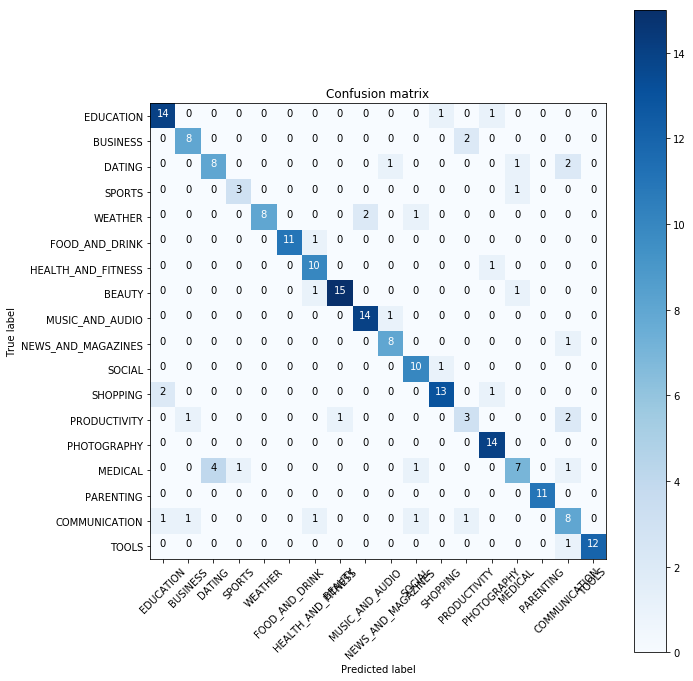

In [124]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, cate)

In [141]:
print(classification_report(y_test, preds))

                    precision    recall  f1-score   support

            BEAUTY       0.78      0.88      0.82        16
          BUSINESS       0.73      0.80      0.76        10
     COMMUNICATION       0.67      0.50      0.57        12
            DATING       0.60      0.75      0.67         4
         EDUCATION       1.00      0.73      0.84        11
    FOOD_AND_DRINK       1.00      0.92      0.96        12
HEALTH_AND_FITNESS       0.77      0.91      0.83        11
           MEDICAL       0.93      0.76      0.84        17
   MUSIC_AND_AUDIO       0.88      0.93      0.90        15
NEWS_AND_MAGAZINES       0.80      0.89      0.84         9
         PARENTING       0.71      0.91      0.80        11
       PHOTOGRAPHY       0.76      0.81      0.79        16
      PRODUCTIVITY       0.43      0.43      0.43         7
          SHOPPING       0.82      1.00      0.90        14
            SOCIAL       0.73      0.57      0.64        14
            SPORTS       1.00      1.00

# TESTING THING

In [ ]:
new_desc = """Find your next commercial real estate deal on the go! Leverage the power of LoopNet anytime, anywhere to find your perfect investment property or lease space right from your Android device. Whether in the office or on the road, the LoopNet app keeps you productive, informed, and ahead of the competition with these features:

• Advanced Search Filters: Find the properties that meet your exact needs using specific search criteria and filtering options.
• Comprehensive Property Details: View listing details including property data, photos, videos, financials, map location, satellite images, and street view. See something you like? Contact the broker right from your phone!
• Map or List Based Search: Customize your search experience. Display and adjust your search results on a map, a list, or both.
• Saved Searches & Notifications: Save searches that matter so you can access them quickly and monitor your market day-to-day. We’ll also keep you notified about new listings that match your saved search criteria.
• Watch List & Notifications: Monitor listings of interest by adding them to your Watch List. We’ll notify you as soon as there are any changes or updates to the listings.
• Multiple Device Capability: Access your saved searches and watched listings from any device or on the web through your LoopNet account.

LoopNet is the industry leader with more traffic, listings, and geographic coverage than any other commercial real estate marketplace. Use the LoopNet app to find your next investment property or space to rent, whether office space, multifamily apartment buildings, retail, restaurant, medical, industrial, or land in all major markets in the United States and Canada including Los Angeles, New York, Chicago, San Francisco, Dallas, Houston, and Miami. """

In [ ]:
x_trial = text_cleaner(new_desc)

In [ ]:
x_vect = tfidf.transform([x_trial])

In [ ]:
x_trial[:100]

In [ ]:
dffff = pd.DataFrame(x_vect.toarray(), columns=tfidf.get_feature_names())